# Part Combination Space Exploration

This is a notebook developed to leverage the new SysML v2 semantics for nested features and instantiation of models to generate instances of $M_1$ system models as feedstock for analysis pipelines.

In [1]:
import requests
import getpass
import math

import time
from pprint import pprint

import json
import networkx as NX

import random
import copy

import json
import pathlib

import ipywidgets
import traitlets
from IPython.display import display

import ipyelk
import ipyelk.nx
from ipyelk.diagram.elk_model import ElkLabel

# Import the SysML v2 API Client
> or install if it's missing...

In [2]:
try:
    import sysml_v2_api_client as sysml2
    from sysml_v2_api_client.rest import ApiException
except ImportError:
    !pip install git+https://github.com/Systems-Modeling/SysML-v2-API-Python-Client.git
    print(
        "Had to install the SysML v2 Python API Client.\n"
        "Restart the kernel and run the notebook again..."
    )

# Configure API Server Connection

In [3]:
SYSML_API_BASE_URL = "http://sysml2-sst.intercax.com:9000"

## Activate APIs

Configure the API client and instantiate the `Project`, `Commit`, and `Element` APIs

In [4]:
configuration = sysml2.Configuration(host=SYSML_API_BASE_URL)

with sysml2.ApiClient(configuration) as client:
    API = dict(
        project=sysml2.ProjectApi(client),
        commits=sysml2.CommitApi(client),
        elements=sysml2.ElementApi(client),
    )

## Pull down commits and elements catalogs

With the API handles, use the pre-built methods to get lists of commits and elements.

In [5]:
kerbal_proj = [
    project
    for project in API["project"].get_projects()
    if project.name.startswith("Kerbal")
    and "Fri Mar 05 18:37:54 UTC 2021" in project.name
][0]
kerbal_proj

{'id': 'f81ed828-1da3-4622-9f7a-98d333ef823a',
 'name': 'Kerbal Fri Mar 05 18:37:54 UTC 2021',
 'type': 'Project'}

In [6]:
# Get commits by project
try:
    commits_response = API["commits"].get_commits_by_project(kerbal_proj.id)
    pprint(commits_response)
except ApiException as exc:
    print(f"Exception when calling CommitApi->get_commits_by_project: {exc}\n")

[{'change': None,
 'containing_project': {'id': 'f81ed828-1da3-4622-9f7a-98d333ef823a'},
 'id': '7bd26615-a993-44dc-ab27-54228937d38b',
 'previous_commit': None,
 'type': 'Commit'}]


In [7]:
try:
    # Get commits by project
    elements = API["elements"].get_elements_by_project_commit(
        kerbal_proj.id,
        commits_response[0].id,
    )
    print(f"Retrieved {len(elements)} elements.\n")
    print("Here are the first 3 elements:")
    pprint(elements[:3])
except ApiException as exc:
    elements = []
    print(f"Could not retrieve elements with the ElementApi->get_elements_by_project_commit: {exc}\n")

Retrieved 100 elements.

Here are the first 3 elements:
[{'id': '009d78a0-fcff-411a-b605-9b20b3678e1c',
 'identifier': '009d78a0-fcff-411a-b605-9b20b3678e1c',
 'type': 'Membership'},
 {'id': '012b5231-b6a4-4603-ae10-b2f7d6cc9814',
 'identifier': '012b5231-b6a4-4603-ae10-b2f7d6cc9814',
 'type': 'PartUsage'},
 {'id': '01793a8c-3afd-41d8-abde-6b63ffe01cf0',
 'identifier': '01793a8c-3afd-41d8-abde-6b63ffe01cf0',
 'type': 'ReturnParameterMembership'}]


# Gather Element Data

Since the generated API doesn't have much detail for elements, need to do this more hands-on.

Not elegant below to just have a larger page size, should implement paging later on.

In [8]:
elements_url = (
    f"{SYSML_API_BASE_URL}"
    f"/projects/{kerbal_proj.id}/commits/{commits_response[0].id}/elements?page[size]=2000"
)
elements_url

'http://sysml2-sst.intercax.com:9000/projects/f81ed828-1da3-4622-9f7a-98d333ef823a/commits/7bd26615-a993-44dc-ab27-54228937d38b/elements?page[size]=2000'

In [9]:
elements_response = requests.get(elements_url)

In [10]:
elements_data = elements_response.json()
print(f"Found data for {len(elements_data)} elements.")

Found data for 497 elements.


Split the elements into relationships and non-relationships. This will let us work with graph representations and a graph understanding of the underlying model.

In [11]:
relations = [
    element
    for element in elements_data
    if 'relatedElement' in element
]
print(f"Found {len(relations)} relationship elements.")

non_relations = [
    element
    for element in elements_data
    if not 'relatedElement' in element
]
print(f"Found {len(non_relations)} non-relationship elements.")

Found 288 relationship elements.
Found 209 non-relationship elements.


In [12]:
ELEMENTS_TO_SHOW = 25

print(f"Here are the fist {ELEMENTS_TO_SHOW} element names and their types sorted by name:")
list(sorted([
    f"""{element["name"]}: {element["@type"]}"""
    for element in non_relations
]))[:ELEMENTS_TO_SHOW]

Here are the fist 25 element names and their types sorted by name:


['$collection: Feature',
 '$collection: Feature',
 '$collection: Feature',
 '$collection: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature',
 '$result: Feature']

# Connect to Semantic Libraries

The real work comes in the connection to the $M_1$ layer and then its interpretation at the $M_0$ layer.

We will start processing the model here.

## Part Definitions and the Usage Features

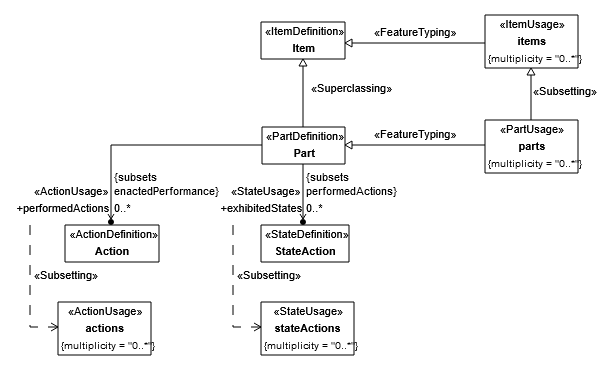

The "parts" feature will always be typed by Part, any additional features applied to a PartDefinition will subset parts.

In [13]:
# Lets create a map for all the elements based on their `id`
elements_by_id = {
    element["@id"]: element
    for element in elements_data
}

# ...and a map for all the ids of a given type
element_ids_by_type = {
    type_: [
        el["@id"]
        for el in elements_data
        if el["@type"] == type_
    ]
    for type_ in set(element["@type"] for element in elements_data)
}

print(f"Found {len(element_ids_by_type)} types.")

Found 38 types.


In [14]:
part_definitions = [
    elements_by_id[id_]
    for id_ in element_ids_by_type["PartDefinition"]
]

print(f"Found {len(part_definitions)} part definitions:")
for part_definition in sorted(part_definitions, key=lambda x: x["name"]):
    print(f"""- {part_definition["name"]}""")

Found 17 part definitions:
- Coupler
- FL-T100 Fuel Tank
- FL-T200 Fuel Tank
- Fuel Tank Section
- Kerbal Rocket Part
- LV-T45 "Swivel" Liquid Fuel Engine
- Liquid Engine
- Liquid Stage
- Mk1 Command Pod
- Parachute
- Pod
- RT-10 "Hammer" Solid Fuel Booster
- RT-5 "Flea" Solid Fuel Booster
- Rocket
- Rocket Stage
- Solid Booster
- Solid Stage


Some old code:
```python
for part_def in part_defs:
    id_memo_dict.update({part_def['@id']: part_def})
```

## Subclassing Graph

Trace the path from the most specialized PartDefinitions back to the library. Pack the results into a graph for later computations on going up and down the specialization tree.

In [15]:
superclasses = [
    elements_by_id[id_]
    for id_ in element_ids_by_type["Superclassing"]
]

print(f"Found {len(superclasses)} superclassing relationships:")
for superclass in superclasses:
    specific = superclass["specific"]["@id"]
    general = superclass["general"]["@id"]
    print(f"""- «{elements_by_id[specific]["name"]}» :> «{elements_by_id[general]["name"]}»""")

Found 13 superclassing relationships:
- «Pod» :> «Kerbal Rocket Part»
- «Fuel Tank Section» :> «Kerbal Rocket Part»
- «Solid Stage» :> «Rocket Stage»
- «FL-T200 Fuel Tank» :> «Fuel Tank Section»
- «Liquid Stage» :> «Rocket Stage»
- «Coupler» :> «Kerbal Rocket Part»
- «LV-T45 "Swivel" Liquid Fuel Engine» :> «Liquid Engine»
- «RT-5 "Flea" Solid Fuel Booster» :> «Solid Booster»
- «Two-Stager» :> «Staging Chart»
- «RT-10 "Hammer" Solid Fuel Booster» :> «Solid Booster»
- «Mk1 Command Pod» :> «Pod»
- «Parachute» :> «Kerbal Rocket Part»
- «FL-T100 Fuel Tank» :> «Fuel Tank Section»


In [16]:
relations[0]["relatedElement"][0]["@id"]

'03f60f67-1bca-4568-b1fe-75ea7358e73c'

## Lets create a graph to store the elements and their relationships

In [17]:
kerbal_model = NX.MultiDiGraph()

kerbal_model.add_nodes_from(
    {
        element["@id"]: element
        for element in non_relations
    }.items()
)
kerbal_model.add_edges_from([
    [
        relation["relatedElement"][0]["@id"],  # source node (str id)
        relation["relatedElement"][1]["@id"],  # target node (str id)
        relation["@type"],                     # edge type (str name)
        relation,                              # edge data (dict)
    ]
    for relation in relations
]);

### We can now draw a superclassing diagram

In [18]:
def get_subgraph_by_edge_type(graph, edge_type, add_ipyelk_data=True):
    subgraph = type(graph)()
    edges = [
        (source, target, data)
        for (source, target, type_), data in graph.edges.items()
        if type_ == edge_type
    ]
    if not edges:
        print(f"Could not find any edges of type: '{edge_type}'!")
        return subgraph

    nodes = {
        node_id: graph.nodes[node_id]
        for node_id in sum([
            [source, target]
            for (source, target, data) in edges
        ], [])  # sum(a_list, []) flattens a_list
    }

    
    for id_, node_data in nodes.items():
        node_data["id"] = id_
        node_data["labels"] = [
            ElkLabel(
                id=f"""type_label_for_{id_}""",
                text=f"""«{node_data["@type"]}»""",
                properties={
                    "cssClasses": "node_type_label",
                },
            ),
            node_data["name"],
        ]

    subgraph.add_nodes_from(nodes.items())
    subgraph.add_edges_from(edges)

    return subgraph


superclass_graph = get_subgraph_by_edge_type(kerbal_model, "Superclassing")
print(f"""`superclass_graph` has {len(superclass_graph.nodes)} nodes and {len(superclass_graph.edges)} edges.""")

`superclass_graph` has 18 nodes and 13 edges.


In [19]:
layouts = ipyelk.nx.XELKTypedLayout()

elk = ipyelk.Elk(
    transformer=ipyelk.nx.XELK(
        source=(superclass_graph, None),
        label_key="labels",
        layouts=layouts.value,
    ),
    style={
        " text.elklabel.node_type_label": {
            "font-style": "italic",
        }
    },
)

def _element_type_opt_change(change):
    elk.transformer.layouts = layouts.value
    elk.refresh()

layouts.observe(_element_type_opt_change, "value")
elk.layout.flex = "1"

box = ipywidgets.HBox([elk, layouts], layout=dict(height="60vh"))

In [20]:
box

In [21]:
# Lets make the diagram look a bit better...
def set_layout_option(widget, category: str, option: str, value):
    category_idxs = [
        int(idx)
        for idx, name in widget._titles.items()
        if name == category
    ]
    if len(category_idxs) != 1:
        raise ValueError(f"Found {len(category_idxs)} entries for '{category}'!")
    category_widget = widget.children[category_idxs[0]]

    option_idxs = [
        int(idx)
        for idx, name in category_widget._titles.items()
        if name == option
    ]
    if len(option_idxs) != 1:
        raise ValueError(f"Found {len(option_idxs)} entries for '{option}' under '{category}'!")

    category_widget.children[option_idxs[0]].value = value


# Make the direction and label placement look better...
set_layout_option(layouts, "Parents", "Direction", "UP")
set_layout_option(layouts, "Label", "Node Label Placement", "H_CENTER V_TOP INSIDE")

### We can still use `matplotlib` if we want to...

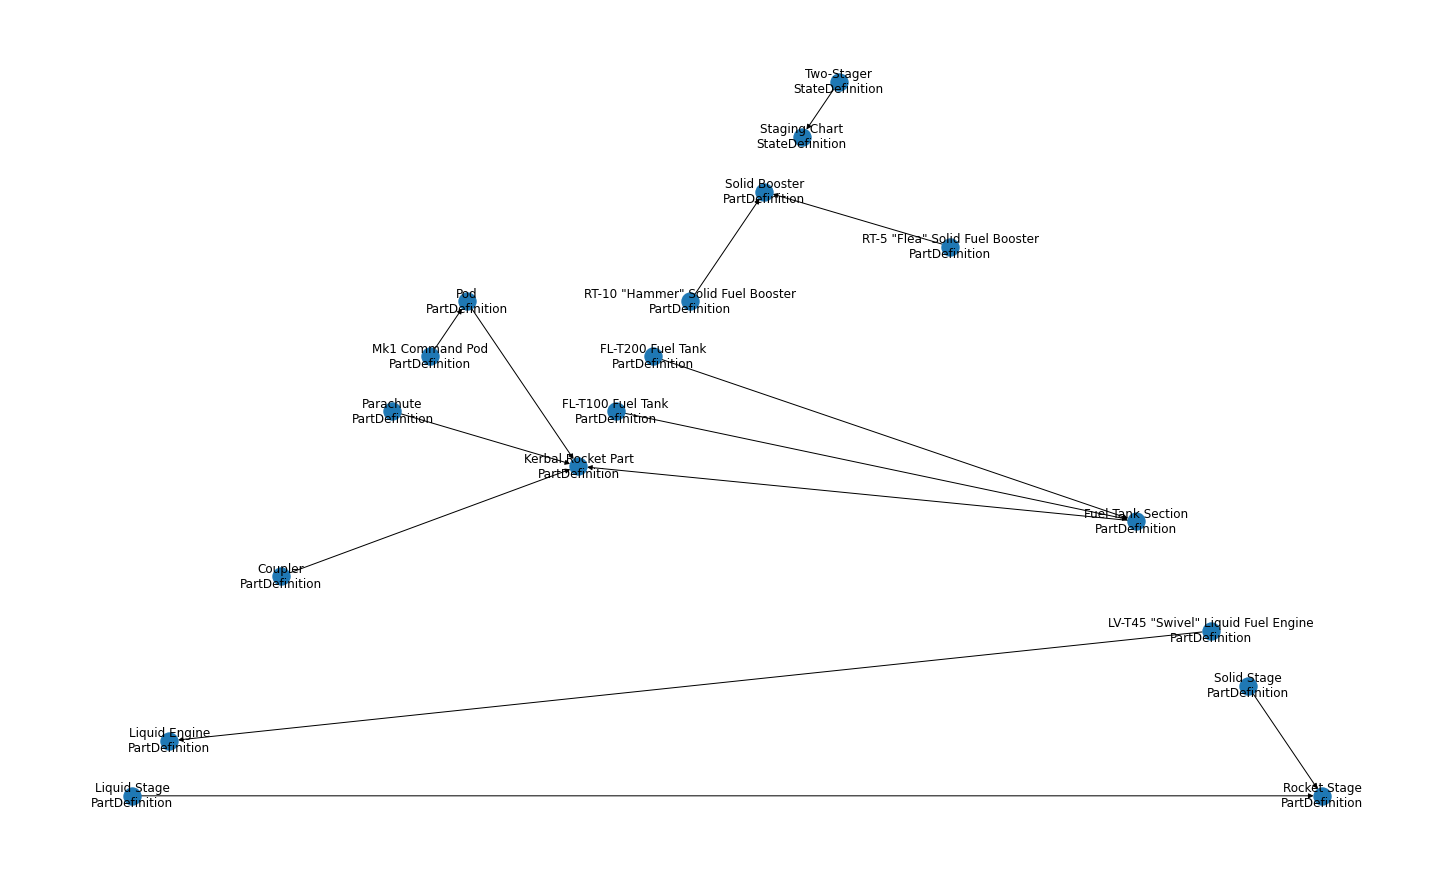

In [35]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 12))
NX.draw_planar(
    superclass_graph,
    labels={
        node: f"""{data["name"]}\n{data["@type"]}"""
        for node, data in superclass_graph.nodes.items()
    },
)

In [24]:
raise NotImplementedError("The rest of the notebook as not been updated yet...")

NotImplementedError: The rest of the notebook as not been updated yet...

## PartUsages

Inspect the features of the part definitions that should go into the features list.

In [ ]:
ids_of_part_uses = element_ids_by_type["PartUsage"]
names_of_part_uses = [elements_by_id[id_]["name"] for id_ in ids_of_part_uses]

print(f"Found {len(part_uses)} part usages: {', '.join(names_of_part_uses)}")

Look for FeatureMemberships and TypeFeaturings to see where the features belong.

In [ ]:
get_subgraph_by_edge_type(kerbal_model, "FeatureMembership")

In [ ]:
elements_by_id["94955cbe-6346-41cc-84da-04658ff4d9d9"]

In [ ]:
feature_members_ids = element_ids_by_type["FeatureMembership"]
type_features_ids = element_ids_by_type["TypeFeaturings"]

In [ ]:
feature_members = [feature_member for feature_member in relations if feature_member['@type'] == 'FeatureMembership']
type_features = [type_feature for type_feature in relations if type_feature['@type'] == 'TypeFeaturings']

In [ ]:
len(feature_members)

In [ ]:
len(type_features)

In [ ]:
part_featuring_graph = NX.DiGraph()

In [ ]:
for fm in feature_members:
    if fm['memberElement']['@id'] in id_memo_dict:
        if id_memo_dict[fm['memberElement']['@id']]['@type'] == 'PartUsage':
            part_featuring_graph.add_edge(fm['memberElement']['@id'], fm['owningType']['@id'])

In [ ]:
[part_featuring_graph.in_degree(node) for node in part_featuring_graph.nodes]

In [ ]:
['{0} is a member of {1}'.format(
    get_name_by_id(fm['memberElement']['@id']), get_name_by_id(fm['owningType']['@id'])
) for fm in feature_members if fm['memberElement']['@id'] in id_memo_dict]

Draw the parts featuring graph.

In [ ]:
part_featuring_graph_labels = {}
for node in part_featuring_graph.nodes():
    part_featuring_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(part_featuring_graph, labels=part_featuring_graph_labels)

Collect multiplicities.

In [ ]:
mults = [mult for mult in non_relations if mult['@type'] == 'MultiplicityRange']
integers = [integer for integer in non_relations if integer['@type'] == 'LiteralInteger']

for mult in mults:
    id_memo_dict.update({mult['@id']: mult})
    
for integer in integers:
    id_memo_dict.update({integer['@id']: integer})

In [ ]:
mult_strings = []
for mult in mults:
    try:
        if mult['lowerBound'] is None and mult['upperBound'] is not None:
            mult_strings.append('[{0}]'.format(
                id_memo_dict[mult['upperBound']['@id']]['value']))
        else:
            mult_strings.append('[{0}..{1}]'.format(
                id_memo_dict[mult['lowerBound']['@id']]['value'],
                id_memo_dict[mult['upperBound']['@id']]['value']))
    except TypeError:
        print('Lower Bound is ' + str(mult['lowerBound']))
        print('Upper Bound is ' + str(mult['upperBound']))

In [ ]:
mult_strings

In [ ]:
def feature_lower_multiplicity(feature):
    if feature['multiplicity'] is not None:
        if '@id' in feature['multiplicity']:
            mult = id_memo_dict[feature['multiplicity']['@id']]
            if '@id' in mult['lowerBound']:
                return id_memo_dict[mult['lowerBound']['@id']]['value']
        
    return 1

In [ ]:
def feature_upper_multiplicity(feature):
    if feature['multiplicity'] is not None:
        if '@id' in feature['multiplicity']:
            mult = id_memo_dict[feature['multiplicity']['@id']]
            if '@id' in mult['upperBound']:
                return id_memo_dict[mult['upperBound']['@id']]['value']
        
    return 1

In [ ]:
['{0} has multiplicity {1}..{2}'.format(
    part_use['name'], feature_lower_multiplicity(part_use), feature_upper_multiplicity(part_use)
) for part_use in part_uses]

Get feature types.

In [ ]:
feature_types = [feature_type for feature_type in relations if feature_type['@type'] == 'FeatureTyping']

In [ ]:
def get_feature_type_name(feature):
    if len(feature['type']) > 0:
        return get_name_by_id(feature['type'][0]['@id'])
    else:
        return 'Part'

In [ ]:
['{0} : {1}'.format(
    get_name_by_id(ft['typedFeature']['@id']), get_name_by_id(ft['type']['@id'])
) for ft in feature_types if ft['typedFeature']['@id'] in id_memo_dict]

# Generate Instances

With the base semantic model in hand, begin to apply the rules to generate our system alternatives.

## Find number of instances for feature last positions

In SysML, the default type is PartDefinition, which is a Classifier, meaning the minimal interpretation of length one (the specific instance). Nesting parts then have an interpretation as expected by systems engineers, namely that the instances "stack" in order to provide a navigation from top-level assembly to leaf component.

In [ ]:
['{0} needs {1} instances of type {2}'.format(
    part_use['name'], feature_upper_multiplicity(part_use), get_feature_type_name(part_use)
) for part_use in part_uses]

Automatically shorten names so that sequences remain readable when printed.

In [ ]:
shorten_pre_bake = {
    'RT-10 "Hammer" Solid Fuel Booster': "RT-10",
    'RT-5 "Flea" Solid Fuel Booster': "RT-5",
    'LV-T45 "Swivel" Liquid Fuel Engine': "LV-T45",
    'FL-T100 Fuel Tank': "FL-T100",
    'FL-T200 Fuel Tank': "FL-T200"
}

In [ ]:
def shorten_name(name):
    short_name = ''
    if len(name) > 5:
        if shorten_pre_bake is not None:
            if name in shorten_pre_bake:
                return shorten_pre_bake[name]
        space_place = name.find(' ')
        if space_place > -1:
            short_name = short_name + name[0]
            short_name = short_name + name[space_place + 1]
            next_space = name.find(' ', space_place + 1)
            while next_space > -1:
                short_name = short_name + name[next_space + 1]
                next_space = name.find(' ', next_space + 1)
            return short_name
    return name

In [ ]:
class Instance():
    def __init__(self, name, index):
        self.name = shorten_name(name) + '#' + str(index)
        
    def __repr__(self):
        return self.name

In [ ]:
multiplicity_dict = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in multiplicity_dict:
        old_val = multiplicity_dict[part_use]
        multiplicity_dict.update({type_name: old_val + feature_upper_multiplicity(part_use)})
    else:
        multiplicity_dict.update({type_name: feature_upper_multiplicity(part_use)})

In [ ]:
multiplicity_dict

## Determine the size of the universe of instances needed for creating alternatives

Use feature membership together with multiplicity to decide how many individuals are needed.

### Building the banded graph

Build up a graph with the SysML v1 banded style of part-type-part-type (with superclassing).

In [ ]:
banded_feature_graph = NX.DiGraph()

In [ ]:
for fm in feature_members:
    if fm['memberElement']['@id'] in id_memo_dict:
        if id_memo_dict[fm['memberElement']['@id']]['@type'] == 'PartUsage':
            banded_feature_graph.add_edge(fm['memberElement']['@id'], fm['owningType']['@id'])

for ft in feature_types:
    if ft['typedFeature']['@id'] in id_memo_dict:
        if id_memo_dict[ft['typedFeature']['@id']]['@type'] == 'PartUsage':
            banded_feature_graph.add_edge(ft['type']['@id'], ft['typedFeature']['@id'])
            
for sup in superclasses:
    if sup['specific']['@id'] in id_memo_dict:
        banded_feature_graph.add_edge(sup['specific']['@id'], sup['general']['@id'])

In [ ]:
banded_feature_graph_labels = {}
for node in banded_feature_graph.nodes():
    banded_feature_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(banded_feature_graph, labels=banded_feature_graph_labels)

In [ ]:
part_leaves = [id_memo_dict[node]
    for node in part_featuring_graph.nodes
        if part_featuring_graph.in_degree(node) == 0]

In [ ]:
part_roots = [id_memo_dict[node]
    for node in part_featuring_graph.nodes
        if part_featuring_graph.out_degree(node) == 0]

In [ ]:
banded_roots = [id_memo_dict[node]
    for node in banded_feature_graph.nodes
        if banded_feature_graph.out_degree(node) == 0]

In [ ]:
[part_leaf['name'] for part_leaf in part_leaves]

In [ ]:
[part_root['name'] for part_root in part_roots]

In [ ]:
[banded_root['name'] for banded_root in banded_roots]

Correct the multiplicities by considering nesting.part_uses

In [ ]:
part_multiplicity = {}

for part_use in part_uses:
    corrected_mult = 0
    for part_tree_root in banded_roots:
        try:
            part_path = NX.shortest_path(banded_feature_graph, part_use['@id'], part_tree_root['@id'])
            # TODO: check that the path actually exists
            corrected_mult = math.prod([feature_upper_multiplicity(id_memo_dict[node]) for node in part_path])
        except NX.NetworkXNoPath:
            pass
    part_multiplicity.update({part_use['@id']: corrected_mult})

In [ ]:
part_multiplicity

### Subdivide Abstract Feature Types

Look at the feature types for where they are abstract and then generate instances from the more specific types.

In [ ]:
[get_name_by_id(node) for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

In [ ]:
corrected_multiplicity_dict = {}
type_id_pairs = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in corrected_multiplicity_dict:
        old_val = corrected_multiplicity_dict[part_use]
        corrected_multiplicity_dict.update({type_name: old_val + part_multiplicity[part_use['@id']]})
    else:
        corrected_multiplicity_dict.update({type_name: part_multiplicity[part_use['@id']]})
        if len(part_use['type']) > 0:
            type_id_pairs.update({type_name: part_use['type'][0]['@id']})

In [ ]:
type_id_pairs

In [ ]:
corrected_multiplicity_dict

## Generate Random Alternatives

Start creating the alternatives with random draws on multiplicity. This will be our space for investigation for weights, thrust-to-weight ratios at stage ignitions, delta-Vs, and initial and burnout masses.

In [ ]:
no_alts_to_create = 50

In [ ]:
partitioned_multiplicity_dicts = []

for step in range(0, no_alts_to_create):

    partitioned_multiplicity_dict = {}

    for key in corrected_multiplicity_dict:
        if key in type_id_pairs:
            key_id = type_id_pairs[key]
            type_obj = id_memo_dict[key_id]
            if type_obj['isAbstract']:
                local_partition = {}
                if key_id in subclassing_graph.nodes:
                    no_splits = len(list(subclassing_graph.successors(key_id)))
                    taken = 0
                    for indx, succ in enumerate(subclassing_graph.successors(key_id)):
                        if indx < no_splits - 1:
                            draw = random.randint(0, corrected_multiplicity_dict[key])
                            taken = taken + draw
                        else:
                            draw = corrected_multiplicity_dict[key] - taken
                        local_partition.update({get_name_by_id(succ): draw})
                partitioned_multiplicity_dict.update({key: local_partition})
            else:
                partitioned_multiplicity_dict.update({key: corrected_multiplicity_dict[key]})
                
    partitioned_multiplicity_dicts.append(partitioned_multiplicity_dict)

In [ ]:
partitioned_multiplicity_dicts[0]

- [ ] TODO: Fix the dictionary to have keys as IDs, not name

In [ ]:
classifier_instance_dicts = []
classifier_memo_dicts = []

for step in range(0, no_alts_to_create):

    classifier_instance_dict = {}
    classifier_memo_dict = {}
    
    partitioned_multiplicity_dict = partitioned_multiplicity_dicts[step]

    for mult_key in partitioned_multiplicity_dict:
        instances_list = []
        if isinstance(partitioned_multiplicity_dict[mult_key], dict):
            for special_key in partitioned_multiplicity_dict[mult_key]:
                sub_instances_list = []
                instances_number = (partitioned_multiplicity_dict[mult_key][special_key] + 1)
                for index in range(1, instances_number):
                    new_instance = Instance(special_key, index)
                    instances_list.append(new_instance)
                    sub_instances_list.append(new_instance)
                    classifier_memo_dict.update({new_instance.name: [special_key, mult_key]})
                classifier_instance_dict.update({special_key: sub_instances_list})
            classifier_instance_dict.update({mult_key: instances_list})
        else:
            instances_number = (corrected_multiplicity_dict[mult_key] + 1)
            for index in range(1, instances_number):
                new_instance = Instance(mult_key, index)
                instances_list.append(new_instance)
                classifier_memo_dict.update({new_instance.name: [mult_key]})
            classifier_instance_dict.update({mult_key: instances_list})
            
    classifier_instance_dicts.append(classifier_instance_dict)
    classifier_memo_dicts.append(classifier_memo_dict)

Now that the universe of instances has been calculated, we can look at how they can be sequenced. This method is probably fragile so will need revisions.
In this case, found that it can't handle unconnected featuring graph components.

In [ ]:
[get_name_by_id(node) for node in NX.topological_sort(part_featuring_graph.reverse())]

In [ ]:
sorted_feature_groups = []

In [ ]:
for comp in NX.connected_components(part_featuring_graph.to_undirected()):
    connected_sub = NX.subgraph(part_featuring_graph, list(comp))
    sorted_feature_groups.append(
        [node for node in NX.topological_sort(connected_sub.reverse())]
    )
    print([get_name_by_id(node) for node in NX.topological_sort(connected_sub.reverse())])

In [ ]:
sorted_feature_groups

In [ ]:
for classifier_instance_dict in classifier_instance_dicts:

    for part_tree_root in part_roots:
        root_name = get_name_by_id(part_tree_root['@id'])
        if root_name not in classifier_instance_dict:
            classifier_instance_dict.update({root_name: Instance(root_name, 1)})

The topological sort on the graph of feature membership determines the order in which to build up sets of instances for features.

In [ ]:
classifier_instance_dicts[0]

In [ ]:
feature_sequence_dictionaries = []

for step in range(0, no_alts_to_create):
    
    classifier_instance_dict = classifier_instance_dicts[step]
    
    feature_sequence_dictionary = {}
    covered_draw_dict = {}
    
    for sorting in sorted_feature_groups:
        for indx, node in enumerate(sorting):
            if indx > 0:
                new_dict = {}
                # get current parent from the graph
                for pred in part_featuring_graph.successors(node):
                    current_parent = pred
                    #print(get_name_by_id(current_parent))

                sequence_of_sequences = []

                for sequence in feature_sequence_dictionary[current_parent]:

                    test_mult = random.randint(
                        feature_lower_multiplicity(id_memo_dict[node]),
                        feature_upper_multiplicity(id_memo_dict[node])
                    )

                    for ind_j in range(0, test_mult):
                        new_sequence = copy.deepcopy(sequence)
                        # find the type of the current feature node
                        node_type = get_feature_type_name(id_memo_dict[node])

                        need_draw = True
                        
                        safety_count = 0

                        while(need_draw and safety_count < 100):

                            draw = random.randint(
                                0,
                                corrected_multiplicity_dict[node_type] - 1
                            )
                            #print(classifier_instance_dict[node_type][draw])

                            if node_type in covered_draw_dict:
                                if classifier_instance_dict[node_type][draw] in covered_draw_dict[node_type]:
                                    pass
                                    #need_draw = False
                                else:
                                    covered_draw_dict[node_type].append(classifier_instance_dict[node_type][draw])
                                    need_draw = False
                            else:
                                covered_draw_dict.update({node_type : [classifier_instance_dict[node_type][draw]]})
                                need_draw = False

                            safety_count = safety_count + 1
                            if safety_count == 99:
                                print('Safety count hit when trying to place ' + 
                                      str(classifier_instance_dict[node_type][draw]) + ' under ' +
                                     str(new_sequence))
                                print('Covered dict is ' + str(covered_draw_dict[node_type]))
                        
                        new_sequence.append(classifier_instance_dict[node_type][draw])

                        sequence_of_sequences.append(new_sequence)

                feature_sequence_dictionary.update({node: sequence_of_sequences})

            elif indx == 0:
                if isinstance(classifier_instance_dict[get_name_by_id(node)], list):
                    starter_list = []
                    for item in classifier_instance_dict[get_name_by_id(node)]:
                        starter_list.append([item])
                    # handle case where main type has more than one instance
                    feature_sequence_dictionary.update({node: starter_list})
                    #print(starter_list)
                    if len(starter_list) == 0:
                        break
                else:
                    feature_sequence_dictionary.update({node: [[classifier_instance_dict[get_name_by_id(node)]]]})
            
    feature_sequence_dictionaries.append(feature_sequence_dictionary)

In [ ]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in feature_sequence_dictionary:
            print(get_name_by_id(key) + ', id ' + key)
            for seq in feature_sequence_dictionary[key]:
                print(str(seq))

# Analyze and Explore Resulting Space

Now that the alternatives have been generated, we can explore the population

In [ ]:
[[get_name_by_id(node), node] for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

## Gather AttributeUsages and literal values

Find all the attribute usages so we can navigate to them from our parts library.

TODO: Look at using FeatureValue relationships for this

In [ ]:
def get_att_literal_values(att_use):
    literal_values = []
    for att_member in att_use['ownedMember']:
        if att_member['@id'] in id_memo_dict:
            if id_memo_dict[att_member['@id']]['@type'] == 'LiteralReal':
                literal_values.append(id_memo_dict[att_member['@id']])
                
    return literal_values

In [ ]:
att_uses = [att_use for att_use in non_relations if att_use['@type'] == 'AttributeUsage']
for att_use in att_uses:
    id_memo_dict.update({att_use['@id']: att_use})

Get literal reals to connect to attributes.

In [ ]:
reals = [real for real in non_relations if real['@type'] == 'LiteralReal']
for real in reals:
    id_memo_dict.update({real['@id']: real})

Create objects to hold different values per instance.

In [ ]:
class ValueHolder():
    
    def __init__(self, path, name, value):
        # path is list of instance references
        self.holder_string = ''
        for indx, step in enumerate(path):
            if indx == 0:
                self.holder_string = str(step)
            else:
                self.holder_string = self.holder_string + '.' + str(step)
        self.holder_string = self.holder_string + '.' + name
        self.value = value
    
    def __repr__(self):
        if self.value is not None:
            return self.holder_string + ' (' + str(self.value) + ')'
        else:
            return self.holder_string + ' (unset)'

Get expressions attached to attributes as values.

In [ ]:
found_ele = [found for found in non_relations if found['@id'] == 'ced4f691-07ff-45dd-a2cd-687bc3bb8942']

In [ ]:
type_values = {}

for att_use in att_uses:
    if len(att_use['ownedMember']) > 0:
        typ = id_memo_dict[att_use['owningType']['@id']]
        for att_member in att_use['ownedMember']:
            for value in get_att_literal_values(att_use):
                print (att_use['name'] + ' of ' + typ['name'] + ' = ' + str(value['value']))
                if att_use['name'] in type_values:
                    type_values[att_use['name']].update({typ['name']: value['value']})
                else:
                    type_values.update({att_use['name']: {typ['name']: value['value']}})

In [ ]:
type_values

- [ ] TODO: Factor the above as sequences of instances rather than going back to the type

## Create Attribute Sequences

Add attributes to the sequences for parts, and where there are values, add those to the sequence also.

In [ ]:
attribute_member_value_graph = NX.DiGraph()

for att in att_uses:
    if att['@id'] in id_memo_dict:
        if id_memo_dict[att['@id']]['@type'] == 'AttributeUsage':
            attribute_member_value_graph.add_edge(att['@id'], att['owningType']['@id'])
            for value in get_att_literal_values(att):
                attribute_member_value_graph.add_edge(value['@id'], att['@id'])

In [ ]:
attribute_member_value_graph_labels = {}
for node in attribute_member_value_graph.nodes():
    if id_memo_dict[node]['@type'] == 'AttributeUsage':
        attribute_member_value_graph_labels.update({node: get_name_by_id(node)})
    elif id_memo_dict[node]['@type'] == 'LiteralReal':
        attribute_member_value_graph_labels.update({node: id_memo_dict[node]['value']})
    
NX.draw_spring(attribute_member_value_graph, labels=attribute_member_value_graph_labels)

### Match Attributes to Classifier types

Where the owningType of the Attribute usage is a classifier, use it as the base of the sequence.

In [ ]:
classifier_instance_dicts[0].keys()

In [ ]:
att_value_dicts = []
value_holders = []

for classifier_instance_dict in classifier_instance_dicts:

    att_value_dict = {}

    for att in att_uses:
        new_sequences = []
        att_owning_type = id_memo_dict[att['owningType']['@id']]
        if att_owning_type['@type'] == 'PartDefinition':
            if att_owning_type['name'] in classifier_instance_dict:
                for instance in classifier_instance_dict[att_owning_type['name']]:
                    new_sequence = []
                    new_sequence.append(instance)
                    
                    #new_sequence.append(att['name'])
                    
                    for value in get_att_literal_values(att):
                        #new_sequence.append(value['@id'])
                        new_holder = ValueHolder([instance], att['name'], value['value'])
                        value_holders.append(new_holder)
                        new_sequence.append(new_holder)
                        
                    if len(get_att_literal_values(att)) == 0:
                        new_holder = ValueHolder([instance], att['name'], None)
                        new_sequence.append(new_holder)
                    new_sequences.append(new_sequence)

        att_value_dict.update({att['@id']: new_sequences})
        
    att_value_dicts.append(att_value_dict)

In [ ]:
for indx, att_value_dict in enumerate(att_value_dicts):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in att_value_dict:
            print(get_name_by_id(key) + ', id ' + key)
            for indx, seq in enumerate(att_value_dict[key]):
                if indx < 5:
                    seq_string = []
                    for member in seq:
                        if isinstance(member, str) and member in id_memo_dict:
                            obj = id_memo_dict[member]
                            # TODO: Create unique value objects for formula mapping
                            if obj['@type'] == 'LiteralReal':
                                seq_string.append(str(obj['value']) + ', id ' + member)
                        else:
                            seq_string.append(member)
                    print(seq_string)
                elif indx == 5:
                    print('..')

## Gather Expressions and Invocations and Build Expression Graph

In [ ]:
expression_graph = NX.DiGraph()
expression_graph_labels = {}
expression_graph_ascii = ''

invocations = []


Memoize InvocationExpressions, BlockExpressions, FeatureReferenceExpressions, and ReferenceUsages

In [ ]:
invocations = [invocation for invocation in non_relations if invocation['@type'] == 'InvocationExpression']
functions = [function for function in non_relations if function['@type'] == 'Function']
op_exprs = [function for function in non_relations if function['@type'] == 'OperatorExpression']
block_exprs = [block_expr for block_expr in non_relations if block_expr['@type'] == 'BlockExpression']
feature_refs = [feature_ref for feature_ref in non_relations if feature_ref['@type'] == 'FeatureReferenceExpression']
reference_uses = [ref_use for ref_use in non_relations if ref_use['@type'] == 'ReferenceUsage']

para_members = [para_member for para_member in relations if para_member['@type'] == 'ParameterMembership']
res_expr_members = [res_expr_member for res_expr_member in relations if res_expr_member['@type'] == 'ResultExpressionMembership']
ret_para_members = [ret_para_member for ret_para_member in relations if ret_para_member['@type'] == 'ReturnParameterMembership']

for invocation in invocations:
    id_memo_dict.update({invocation['@id']: invocation})
    
for function in functions:
    id_memo_dict.update({function['@id']: function})
    
for op_expr in op_exprs:
    id_memo_dict.update({op_expr['@id']: op_expr})
    
for block_expr in block_exprs:
    id_memo_dict.update({block_expr['@id']: block_expr})
    
for feature_ref in feature_refs:
    id_memo_dict.update({feature_ref['@id']: feature_ref})
    
for reference_use in reference_uses:
    id_memo_dict.update({reference_use['@id']: reference_use})

In [ ]:
ofms = []
ofms.extend(para_members)
ofms.extend(res_expr_members)
ofms.extend(ret_para_members)

Get feature memberships from the expressions to their members.

In [ ]:
for fm in feature_members:
    if fm['owningType']['@id'] in id_memo_dict:
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'InvocationExpression':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'Function':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
            expression_graph_labels.update({fm['owningType']['@id']: id_memo_dict[fm['owningType']['@id']]['name']})
        if id_memo_dict[fm['owningType']['@id']]['@type'] == 'OperatorExpression':
            expression_graph.add_edge(fm['owningType']['@id'], fm['memberFeature']['@id'])
            expression_graph_labels.update({fm['owningType']['@id']: id_memo_dict[fm['owningType']['@id']]['operator']})
            if fm['memberFeature']['@id'] in id_memo_dict:
                if id_memo_dict[fm['memberFeature']['@id']]['@type'] == 'FeatureReferenceExpression':
                    expression_graph_labels.update({fm['memberFeature']['@id']: 
                                                   id_memo_dict[id_memo_dict[fm['memberFeature']['@id']]['referent']['@id']]['name'] + ' (FeatRef)'})

for ofm in ofms:
    if ofm['owningType']['@id'] in id_memo_dict:
        if id_memo_dict[ofm['owningType']['@id']]['@type'] == 'BlockExpression':
            expression_graph.add_edge(ofm['owningType']['@id'], ofm['memberFeature']['@id'])
            if ofm['memberFeature']['@id'] in id_memo_dict:
                if id_memo_dict[ofm['memberFeature']['@id']]['@type'] == 'FeatureReferenceExpression':
                    expression_graph_labels.update({ofm['memberFeature']['@id']: 
                                                   id_memo_dict[id_memo_dict[ofm['memberFeature']['@id']]['referent']['@id']]['name'] + ' (FeatRef)'})
            if get_name_by_id(ofm['memberFeature']['@id']) is not None:
                if get_metatype_by_id(ofm['memberFeature']['@id']) == 'ReferenceUsage':
                    ref_type_name = id_memo_dict[id_memo_dict[ofm['memberFeature']['@id']]['type'][0]['@id']]['name']
                    expression_graph_labels.update({ofm['memberFeature']['@id']: 
                                                    get_name_by_id(ofm['memberFeature']['@id']) + ':' + ref_type_name})
                else:
                    expression_graph_labels.update({ofm['memberFeature']['@id']: get_name_by_id(ofm['memberFeature']['@id'])})
                    
for ft in feature_types:
    if ft['typedFeature']['@id'] in id_memo_dict:
        if id_memo_dict[ft['type']['@id']]['@type'] == 'Function':
            expression_graph.add_edge(ft['typedFeature']['@id'], ft['type']['@id'])
            expression_graph_labels.update({ft['type']['@id']: id_memo_dict[ft['type']['@id']]['name']})

Gather the body and parameters of the invocation.

In [ ]:
NX.draw_spring(expression_graph, labels=expression_graph_labels)

## Perform Staging Mass Analysis

- [ ] TODO: Strengthen this with analyses that actually do the calculation
- [ ] TODO: Accommodate associations between tanks and engines to make delta-V and Isp calculations work properly

This is very specific to a given calculation - need to have a kernel for expanding the calculations just as with inspecting type hierarchy and multiplicity

In [ ]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    no_stages = len(feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'])
    print(str(no_stages))
    for stag in range(1, no_stages + 1):
        stage_empty_mass = 0
        stage_full_mass = 0
        stage_specific_impulse = 0
        # add up the starter mass for the stage and the burnout mass
        stage_instance = feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'][stag - 1][-1]
        print(str(stage_instance) + ": " + str(classifier_memo_dicts[indx][stage_instance.name]))
        if '54c2e565-ede4-4c12-a44c-2277566a2861' in feature_sequence_dictionary:
            booster_instances = \
                [booster[-1] for booster in feature_sequence_dictionary['54c2e565-ede4-4c12-a44c-2277566a2861']
                     if str(booster[0]) == str(stage_instance)]
            print('Booster instance length = ' + str(len(booster_instances)))
            for booster in booster_instances:
                for clz in classifier_memo_dicts[indx][booster.name]:
                    if clz in partitioned_multiplicity_dicts[indx]:
                        pass
                    else:
                        empty_mass = type_values['Empty Mass'][clz]
                        full_mass = type_values['Full Mass'][clz]
                        specific_impulse = type_values['Specific Impulse'][clz]

                        stage_empty_mass = stage_empty_mass + empty_mass
                        stage_full_mass = stage_full_mass + full_mass
                        stage_specific_impulse = stage_specific_impulse + specific_impulse
            if len(booster_instances) > 0:
                stage_specific_impulse = stage_specific_impulse / len(booster_instances)
        
        if stage_empty_mass > 0.0:
            booster_delta_V = 9.81 * stage_specific_impulse * math.log(stage_full_mass / stage_empty_mass)
        
        if indx < 3:
            print ('Stage booster full mass is ' + str(stage_full_mass))
            print ('Stage booster empty mass is ' + str(stage_empty_mass))
            print ('Stage booster specific impulse is ' + str(stage_specific_impulse))
            print ('Stage booster delta-V is ' + str(booster_delta_V))